<a href="https://colab.research.google.com/github/LombardoAndrea195/Beam_examples/blob/main/Beam_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### A Beam pipeline is a graph (specifically, a directed acyclic graph) where data is processed from input to output. This includes reading input data, transforming that data, and writing output data. A pipeline is constructed by a user in their SDK of choice. Then, the pipeline makes its way to the runner either through the SDK directly or through the Runner API’s RPC interface. 
[Link pattern](https://beam.apache.org/documentation/patterns/overview/)

#####Pipelines are built using PCollection and PTransform in detail the firs is used for collect data batch and data stream instead the second is used as container for describe the transformation of data, it's applied to a PCollection.
PCollection is an unordered bag of elements.There is no upper limit on how many elements a PCollection can contain. Multiple pipelines cannot share a PCollection. Beam pipelines process PCollections, and the runner is responsible for storing these elements.

A PCollection generally contains “big data” (too much data to fit in memory on a single machine). Therefore, the elements of a PCollection cannot be processed individually, and are instead processed uniformly in parallel.
A PCollection can be either bounded or unbounded.
A bounded PCollection is a dataset of a known, fixed size (alternatively, a dataset that is not growing over time). Bounded data can be processed by batch pipelines.
An unbounded PCollection is a dataset that grows over time, and the elements are processed as they arrive. Unbounded data must be processed by streaming pipelines.

In [ ]:
!pip install apache_beam

In [5]:
from google.colab import files
uploaded=files.upload()

Saving dept_data.txt to dept_data.txt


####Implementation:
1.   Import the library
2.   Create and giving a pipeline name
3.   Create a Pcollection for reading from source data
4.   Apply PTransoform for modifying the informations according requirements
5.   Retrive to an output

A transform does not modify the input or dirty it — remember that a PCollection is immutable by definition. A could tricky improvement is to apply multiple transforms to the same input PCollection to create a branching pipeline for applying different use cases.



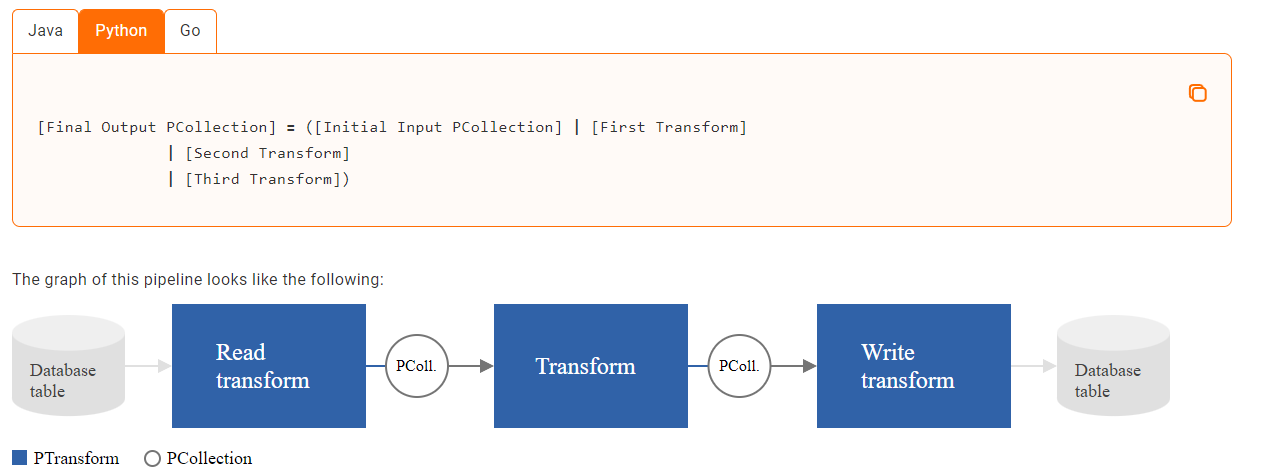




In [ ]:
import apache_beam as beam
 #classic use case read from file and write to a file 
Pipeline_1=beam.Pipeline()

Transoformation_Layer=(        
    Pipeline_1

              |beam.io.ReadFromText(file_pattern='dept_data.txt') #input data from a specific file and consider each line as a new element 
              |beam.Map(lambda record: record.split(','))

              #|beam.Filter(filtering)
              |beam.Filter(lambda record: record[3] == 'Accounts')
              
              |beam.Map(lambda record: (record[1], 1))
              |beam.CombinePerKey(sum)
              
              |beam.io.WriteToText('data/output_new_final')
    )
Pipeline_1.run() #run the pipeline


######N.B. A different approach is to use AVRO schema. Avro is a row-oriented remote procedure call. It uses JSON for defining data types and protocols, and serializes data in a compact binary format.The serialization format is used for persistent data, and a wire format for communication between Hadoop nodes, and from client programs to the Hadoop services. Avro uses a schema to structure the data that is being encoded. 
Other possibilities for input:
1.  ReadFromAvro() -> Avro file perform serialization schema Json->serialized in a compact binary format
2.  ReadFromParquet() -> Parquet file is a kind of file which perform the compression
3.  ReadFromTFRecord() ->read from tensor flow records. The record is refered to storing a sequence of binary records
4.  ReadFromPubSub() -> provider service Google
5.  Create(("key",[value])) #the value could be a list


Other possibilities for output:


1.  WriteToAvro() -> Avro file perform serialization schema Json->serialized in a compact binary format
2.  WriteToParquet() -> Parquet file is a kind of file which perform the compression
3.  ReadFromTFRecord() ->read from tensor flow records. The record is refered to storing a sequence of binary records
4.  WriteToPubSub() -> provider service Google
5.  WriteToText(("key",[value])) #the value could be a list


In [ ]:
!cat data/output_new_final-00000-of-00001

In [15]:
x=",ssdsdsmsd,sdsd,sds"
x.split(",")

['', 'ssdsdsmsd', 'sdsd', 'sds']

Difference between Transformers:
1.  Map->used for a 1 to 1 mapping. In the specific context took an element so a row and split with concluding with a collection of element(list) separated by a coma
2.  FlatMap-> make a similar use case as Map but different from it the outcome is not a single value but a multiple values.
3.  Filter-> make a filter from the entire dataframe to a specific element.

In [ ]:
#input data from
import apache_beam as beam
 
Pipeline_1=beam.Pipeline()

Transoformation_Layer=(        
    Pipeline_1
              #step for comment and debug step by step
              |'Read from input' >> beam.Create([
                  'To be, or not to be: that is the question: ',
                  "Whether 'tis nobler in the mind to suffer ",
                  'The slings and arrows of outrageous fortune, ',
                  'Or to take arms against a sea of troubles, ',
              ]) #input data in memory
              |beam.Map(lambda record: record.split(','))

              #|beam.Filter(filtering)
              |beam.Filter(lambda record: record[3] == 'Accounts')
              
              |beam.Map(lambda record: (record[1], 1))
              |beam.CombinePerKey(sum)
              
              |beam.io.WriteToText('data/output_new_final')
    )
Pipeline_1.run()


A different behaviour of it is to split the pipeline in branches:

In [16]:
import apache_beam as beam

def SplitRow(element):
    return element.split(',')

p = beam.Pipeline()


input_collection = ( 
                      p 
                      | "Read from text file" >> beam.io.ReadFromText('dept_data.txt')
                      | "Split rows" >> beam.Map(SplitRow)
                   )

accounts_count = (
                      input_collection
                      | 'Get all Accounts dept persons' >> beam.Filter(lambda record: record[3] == 'Accounts')
                      | 'Pair each accounts employee with 1' >> beam.Map(lambda record: ("Accounts, " +record[1], 1))
                      | 'Group and sum1' >> beam.CombinePerKey(sum)
                    #  | 'Write results for account' >> beam.io.WriteToText('data/Account')
                 )

hr_count = (
                input_collection
                | 'Get all HR dept persons' >> beam.Filter(lambda record: record[3] == 'HR')
                | 'Pair each hr employee with 1' >> beam.Map(lambda record: ("HR, " +record[1], 1))
                | 'Group and sum' >> beam.CombinePerKey(sum)
                #| 'Write results for hr' >> beam.io.WriteToText('data/HR')
           )

output =(
         (accounts_count,hr_count)
    | beam.Flatten()
    | beam.io.WriteToText('data/both')
)



p.run()